# start

from 0322_6; oversample pos cases

In [18]:
PRFX='0323_1'
trntmstmp=1584412344
valtmstmp=1585069785
import datetime
print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (trntmstmp, valtmstmp)])

grand_total=1.5e8
MIN_TM_TRN=1580947200
MIN_TM_TST=1581552000
print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (MIN_TM_TRN, MIN_TM_TST)])


CHNKSZ=1e6

['2020-03-17 02:32:24', '2020-03-24 17:09:45']
['2020-02-06 00:00:00', '2020-02-13 00:00:00']


# setup

In [71]:
from pathlib import Path
# import dask
# print('dask.__version__', dask.__version__)
import xgboost as xgb
# import dask_xgboost
# import dask.dataframe as dd
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from dask.distributed import Client
import pickle
import lightgbm as lgb
from tqdm import tqdm
from collections import Counter
pd.set_option('display.max_rows', 500)

from functools import reduce
import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

SEED=101
HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# https://towardsdatascience.com/how-to-calibrate-undersampled-model-scores-8f3319c1ea5b
# How to use the function?
# Let’s say your goal is to generate a model that shows the credit default probabilities and your original 
# training data has 50,000 rows with only 500 of them labeled as target class. When you sample your non-target 
# instances randomly and reduce the total row count to 10,000, while conserving 500 target rows, our calibration
# function becomes:
# calibration(model_results, 50000, 500, 10000, 500)
# Here model_results is your model probability output array. After you train your model and put the results in it, your function is ready to use. 

def calibration(data, train_pop, target_pop, sampled_train_pop, sampled_target_pop):
    calibrated_data = \
    ((data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)) /
    ((
        (1 - data) * (1 - target_pop / train_pop) / (1 - sampled_target_pop / sampled_train_pop)
     ) +
     (
        data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)
     )))

    return calibrated_data

cols=[
'toks',
'hshtgs',
'twtid',
'media',
'links',
'domns',
'twttyp',
'lang',
'tm',

'u1id',
'u1_fllwer_cnt',
'u1_fllwng_cnt',
'u1_vrfed',
'u1_create_tm',

'u2id',
'u2_fllwer_cnt',
'u2_fllwng_cnt',
'u2_vrfed',
'u2_create_tm',

'u1_fllw_u2',
'reply_tm',
'retwt_tm',
'retwt_cmmnt_tm',
'like_tm',
]

cols_val = cols[:-4]
cols_tgt_tmstmp=[
    'retwt_tm',
    'reply_tm',
    'like_tm',
    'retwt_cmmnt_tm',
]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
ntgts=len(tgts)

tgt2col=dict(zip(tgts,cols_tgt))
tgt2col

{'Retweet': 'retwt',
 'Reply': 'reply',
 'Like': 'like',
 'RTwCmnt': 'retwt_cmmnt'}

# prepare data

## get maps from test set

In [20]:
# dfval=dd.read_csv(
#     f'{p_in}/val_{valtmstmp}.tsv',
#     sep='\x01', header=None, names=cols_val,)
# lang2cnt=dict(dfval.lang.value_counts().compute())
# ttl=sum(lang2cnt.values())
# lang2perc={k:v/ttl for k,v in lang2cnt.items()}
langs=['D3164C7FBCF2565DDF915B1B3AEFB1DC', '22C448FF81263D4BAF2A176145EE9EAD', '06D61DCBBE938971E1EA0C38BD9B5446', 'ECED8A16BE2A5E8871FD55F4842F16B1', 'B9175601E87101A984A50F8A62A1C374', '4DC22C3F31C5C43721E6B5815A595ED6', '167115458A0DBDFF7E9C0C53A83BAC9B', '125C57F4FA6D4E110983FB11B52EFD4E', '022EC308651FACB02794A8147AEE1B78', 'FA3F382BC409C271E3D6EAF8BE4648DD', '9BF3403E0EB7EA8A256DA9019C0B0716', '975B38F44D65EE42A547283787FF5A21', '2996EB2FE8162C076D070A4C8D6532CD', 'FF60A88F53E63000266F8B9149E35AD9', '717293301FE296B0B61950D041485825', '3E16B11B7ADE3A22DDFC4423FBCEAD5D', '3820C29CBCA409A33BADF68852057C4A', '9ECD42BC079C20F156F53CB3B99E600E', '76B8A9C3013AE6414A3E6012413CDC3B', 'AEF22666801F0A5846D853B9CEB2E327', '190BA7DA361BC06BC1D7E824C378064D', '1FFD2FE4297F5E70EBC6C3230D95CB9C', 'A0C7021AD8299ADF0C9EBE326C115F6F', 'D413F5FE5236E5650A46FD983AB39212', '48236EC80FDDDFADE99420ABC9210DDF', '691890251F2B9FF922BE6D3699ABEFD2', '920502FAA080485768AA89BC96A55C47', '0331BF70E606D62D92C96CE9AD71A7CF', '89616CFF8EC8637092F885C7EFF43D74', '06BEAB41D66CCFF329D1ED8BA120A6C2', '60FBA0E834CC59D647C3599AD763FFDF', 'C7A400D9AD489ACF673CF12FBB80AAE5', 'E59EF8BB86A6D815331DDF4C467CE0C7', '4249CE88433AEA3F8DCEECF008B3CB95', '544FA32458C903F1125FE6598300A047', 'CB11E9CF42BD0A1BAD5E27BF3422D99D', '3A85BCEC571C3F5AB1069E4924189177', 'FF7EABB5A382356D54D9C41BA0125E09', 'E7BB61D2A87C1E72DF1C7BC292B86A1C', '69C4A33B9AD29AF883D60BA61CC08702', 'F4FD40A716F1572C9A28E9CAA58BE3A5', '259A6F6DFD672CB1F883CBEC01B99F2D', '6431A618DCF7F4CB7F62A95A39BAB77A', '3121F7240D488F74EEED9312E174B217', '54208B51D44E7D91DC2F3DD02ADEDEC2', 'DBEEFB80F8A314311E2B4BD593E11DFE', 'B6D90127A09AB1229731898AEF9D4D7C', 'F3E1016563360F9434FA986CA86C249C', '2216D01F7B48554E4211021A46816FCF', '1BC639981AE88E09129594B11F894A21', 'C942E369C88CE7C56E69A84D04319FF0', '57ADD4576E2AD6648E9B2DE32F3462A5', 'AC1F0671A4B0D5B8112F87DE7B490E6D', 'C2EF5FABE7619D8A333D5F0FF76E1BFA', 'AA0254541959271ED3453119B787D0C3', 'A6B70CDF8C7B934D4A218CA9B6B7FDB4', 'BF477808A37E3E4E9C5D9F1839E8519E', '97F81BD92A1ACA3F1F43C154E689350F', '60A3DB168094D41241E45E0DE3539BC0', '12D8CEB94F89D11D7EB95EAE9689B009', 'F73266A79468BB89C4325FDEDB0B533C', '4690215948DBF6872B8ED1C2BC87B17E', 'D18801336202297E6484F634CAC6592E', '2E18F6F53E3CF073911AF0A93BBE5373', 'B2235C8B73239FDC5780DD132419833A', '515E873C86EE1577E75FA2387B7FA59E',]

# dfval.twttyp.value_counts().compute()
# TopLevel    2932
# Retweet      994
# Quote        213
twttyps=['TopLevel','Retweet','Quote']

## prep func

In [21]:
def prp_df(df, istrn=True):
    tm_min = MIN_TM_TRN if istrn else MIN_TM_TST
    df['len_toks'] = df.toks.apply(len)
    for media in ['Photo', 'Video', 'GIF']:
        df[f'has_media_{media}'] = df.media.fillna('').apply(lambda x: media in x)
    for col in ['hshtgs', 'links', 'domns',]:
        df[f'num_{col}'] = df[col].fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0)
    
    df['twt_age'] = df.tm - tm_min
    df['u1_age']  = df.tm - df.u1_create_tm
    df['u2_age']  = df.tm - df.u2_create_tm
        
    tm_dt=pd.to_datetime(df.tm, unit='s')
    df['tm_dayofweek']=tm_dt.dt.dayofweek
    df['tm_hour']=tm_dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    for typ in twttyps:
        df[f'twttyp_{typ}']=(df.twttyp==typ).astype('int8')

    for lang in langs:
        df[f'lang_{lang}']=(df.lang==lang).astype('int8')
    if istrn: 
        df[cols_tgt]=df[cols_tgt_tmstmp].notna().astype('int8')
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 
                                       'tm', 'u1_create_tm','u2_create_tm', 'u1id', 'u2id', 'twtid', ]+cols_tgt_tmstmp, )
    else:
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 
                                       'tm', 'u1_create_tm','u2_create_tm', 'u1id', ])        
    return df

In [22]:
grand_total, grand_total/CHNKSZ

(150000000.0, 150.0)

## valid data

In [23]:
chnks_trn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',
                    header=None,names=cols, 
                        chunksize=CHNKSZ)
# first chunk as validate data
for ichnk,df in enumerate(chnks_trn):
    print(dtnow(), 'chunk', ichnk)
    print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') 
           for o in (df.tm.min(), df.tm.max())])
    dfvalid = prp_df(df)
    break
dfvalid.shape

cols_feat=[o for o in dfvalid.columns if o not in cols_tgt]

# Xvl,yvl=dfvl[cols_feat],dfvl[cols_tgt]

2020-03-23 17:45:33 chunk 0
['2020-02-06 00:00:00', '2020-02-12 23:59:59']


## trnval data func

In [24]:
tgt=tgts[1]
tgtcol=tgt2col[tgt]

chnks_trn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',
                    header=None,names=cols, 
                        chunksize=CHNKSZ)
len_df_wanted = int(CHNKSZ)
# retwt          0.113031
# reply          0.027488
# like           0.439499
# retwt_cmmnt    0.007742
pos_rate_wanted = 0.1
n_pos_wanted = int(len_df_wanted*pos_rate_wanted)
print('n_pos_wanted', n_pos_wanted)
np.random.seed(SEED)
lst_df = []
n_pos_ttl = 0
for ichnk,df in enumerate(chnks_trn):
    #skip first chunk (it was validate data)
    if ichnk==0: continue
    print(dtnow(), 'chunk', ichnk)
    df = prp_df(df)
    n_pos_ttl+= df[tgtcol].sum()
    lst_df.append(df)
    if n_pos_ttl>=n_pos_wanted: break

df = pd.concat(lst_df)
df.reset_index(drop=True,inplace=True)


# https://stackoverflow.com/questions/28556942/pandas-remove-rows-at-random-without-shuffling-dataset
idx_neg=np.where(df[tgtcol]==0)[0]
n_neg = len(idx_neg)
n_pos = len(df)-len(idx_neg)
n_neg2keep = len_df_wanted-n_pos
n_neg2rmv = n_neg-n_neg2keep
idx_neg2rmv = np.random.choice(idx_neg, n_neg2rmv, replace=False)
dftrvl = df.drop(idx_neg2rmv)
print('dftrvl.shape:',dftrvl.shape,'dftrvl[tgtcol].mean():',dftrvl[tgtcol].mean())

pops={
    'train_pop':len(df),
    'target_pop':n_pos,
    'sampled_train_pop':len_df_wanted,
    'sampled_target_pop':n_pos,
}
print(pops)

n_pos_wanted 100000
2020-03-23 17:45:56 chunk 1
2020-03-23 17:46:11 chunk 2
2020-03-23 17:46:27 chunk 3
2020-03-23 17:46:42 chunk 4
dftrvl.shape: (1000000, 95) dftrvl[tgtcol].mean(): 0.109752
{'train_pop': 4000000, 'target_pop': 109752, 'sampled_train_pop': 1000000, 'sampled_target_pop': 109752}


In [25]:
dftrvl.head()

,u1_fllwer_cnt,u1_fllwng_cnt,u1_vrfed,u2_fllwer_cnt,u2_fllwng_cnt,u2_vrfed,u1_fllw_u2,len_toks,has_media_Photo,has_media_Video,...,lang_F73266A79468BB89C4325FDEDB0B533C,lang_4690215948DBF6872B8ED1C2BC87B17E,lang_D18801336202297E6484F634CAC6592E,lang_2E18F6F53E3CF073911AF0A93BBE5373,lang_B2235C8B73239FDC5780DD132419833A,lang_515E873C86EE1577E75FA2387B7FA59E,retwt,reply,like,retwt_cmmnt
0,13537,114,False,95,354,False,False,214,True,False,...,0,0,0,0,0,0,1,0,0,0
4,5210115,1583,True,226,330,False,False,381,True,False,...,0,0,0,0,0,0,0,0,0,0
7,499123,1596,True,13,77,False,False,583,True,False,...,0,0,0,0,0,0,0,0,1,0
11,972,811,False,741,736,False,True,181,False,False,...,0,0,0,0,0,0,0,1,1,0
20,986,1842,False,114,1098,False,False,295,False,False,...,0,0,0,0,0,0,0,0,1,0


In [26]:
# df.columns

In [27]:
dftrvl = dftrvl.sample(len(dftrvl))

In [28]:
# tgt2ytr={tgt:ytr.iloc[:,i] for i,tgt in enumerate(tgts)}
# tgt2yvl={tgt:yvl.iloc[:,i] for i,tgt in enumerate(tgts)}

In [29]:
def getdftrvl(tgt):
    print(tgt)
    tgtcol=tgt2col[tgt]
    chnks_trn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',
                        header=None,names=cols, 
                            chunksize=CHNKSZ)
    len_df_wanted = int(CHNKSZ)
    # retwt          0.113031
    # reply          0.027488
    # like           0.439499
    # retwt_cmmnt    0.007742
    pos_rate_wanted = 0.1
    n_pos_wanted = int(len_df_wanted*pos_rate_wanted)
    print('n_pos_wanted', n_pos_wanted)
    np.random.seed(SEED)
    lst_df = []
    n_pos_ttl = 0
    for ichnk,df in enumerate(chnks_trn):
        #skip first chunk (it was validate data)
        if ichnk==0: continue
        print(dtnow(), 'chunk', ichnk)
        df = prp_df(df)
        n_pos_ttl+= df[tgtcol].sum()
        lst_df.append(df)
        if n_pos_ttl>=n_pos_wanted: break

    df = pd.concat(lst_df)
    df.reset_index(drop=True,inplace=True)


    # https://stackoverflow.com/questions/28556942/pandas-remove-rows-at-random-without-shuffling-dataset
    idx_neg=np.where(df[tgtcol]==0)[0]
    n_neg = len(idx_neg)
    n_pos = len(df)-len(idx_neg)
    n_neg2keep = len_df_wanted-n_pos
    n_neg2rmv = n_neg-n_neg2keep
    idx_neg2rmv = np.random.choice(idx_neg, n_neg2rmv, replace=False)
    dftrvl = df.drop(idx_neg2rmv)
    dftrvl = dftrvl.sample(len(dftrvl))
    print('dftrvl.shape:',dftrvl.shape,'dftrvl[tgtcol].mean():',dftrvl[tgtcol].mean())

    pops={
        'train_pop':len(df),
        'target_pop':n_pos,
        'sampled_train_pop':len_df_wanted,
        'sampled_target_pop':n_pos,
    }
    print(pops)
    return dftrvl, pops

# model

In [30]:
def train(params,dtr,dvl):
    print(params)
    evals_result = {}
    evallist = [(dtr, 'train'), (dvl, 'eval')]
    bst = xgb.train(params=params, dtrain=dtr, num_boost_round=1000, 
                    evals=evallist, evals_result=evals_result, 
                    verbose_eval=50,
                    early_stopping_rounds=10)
    return bst,evals_result

def valid(bst,dtr,dvl):
    prdtr = bst.predict(dtr, ntree_limit=bst.best_ntree_limit)
    prdvl = bst.predict(dvl, ntree_limit=bst.best_ntree_limit)
    return prdtr,prdvl

def do_tgt(tgt):
    params=tgt2params[tgt]
    tgtcol=tgt2col[tgt]
    dftrvl, pops=getdftrvl(tgt)
    split=int(len(dftrvl)*0.85)
    dftr,dfvl=dftrvl[:split],dftrvl[split:]
    dtr = xgb.DMatrix(dftr[cols_feat], label=dftr[tgtcol], feature_names=cols_feat)
    dvl = xgb.DMatrix(dfvl[cols_feat], label=dfvl[tgtcol], feature_names=cols_feat)
    bst,evals_result=train(params,dtr,dvl)
    prdtr,prdvl=valid(bst,dtr,dvl)
    
    tgt2bst[tgt]=bst
    tgt2evalres[tgt]=evals_result
    tgt2ytr[tgt]=dftr[tgtcol]
    tgt2yvl[tgt]=dfvl[tgtcol]
    tgt2pops[tgt]=pops
    tgt2prdtr[tgt]=prdtr
    tgt2prdvl[tgt]=prdvl

In [37]:
tgt2params = {k:{'objective': 'binary:logistic',
    'verbosity': 1,
    'eval_metric': [ 'aucpr','logloss',],
} for k in tgts}

tgt2bst={}
tgt2evalres={}
tgt2ytr={}
tgt2yvl={}
tgt2prdtr={}
tgt2prdvl={}
tgt2pops={}
for tgt in tgts:
    print(dtnow(), tgt, '*'*80)
    do_tgt(tgt)
    
pickle.dump(tgt2bst, open(f"{p_out}/tgt2bst.p", "wb"))

2020-03-23 18:18:32 Retweet ********************************************************************************
Retweet
n_pos_wanted 100000
2020-03-23 18:18:48 chunk 1
dftrvl.shape: (1000000, 95) dftrvl[tgtcol].mean(): 0.112823
{'train_pop': 1000000, 'target_pop': 112823, 'sampled_train_pop': 1000000, 'sampled_target_pop': 112823}
{'objective': 'binary:logistic', 'verbosity': 1, 'eval_metric': ['aucpr', 'logloss']}
[0]	train-aucpr:0.26093	train-logloss:0.53271	eval-aucpr:0.25517	eval-logloss:0.53346
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 10 rounds.
[50]	train-aucpr:0.34080	train-logloss:0.30412	eval-aucpr:0.31134	eval-logloss:0.31280
[100]	train-aucpr:0.36405	train-logloss:0.29818	eval-aucpr:0.31814	eval-logloss:0.31091
Stopping. Best iteration:
[94]	train-aucpr:0.36161	train-logloss:0.29870	eval-aucpr:0.31803	eval-logloss:0.31090

2020-03-23 18:20:18 Reply **********************************

# analyze

## tr vl

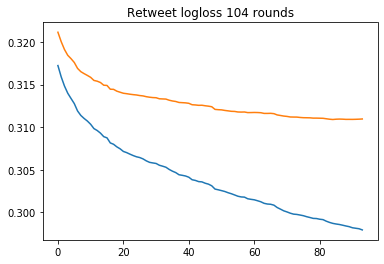

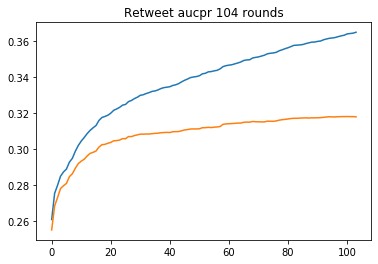

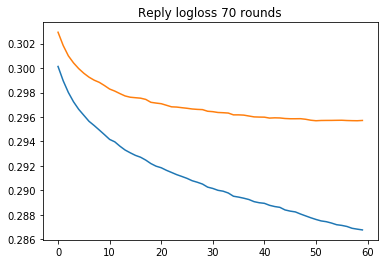

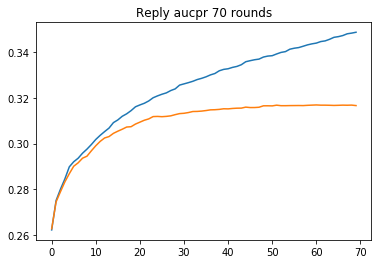

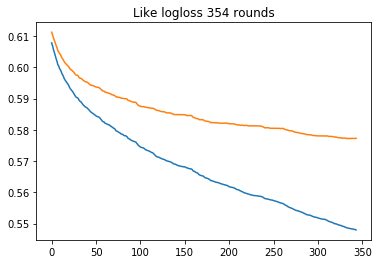

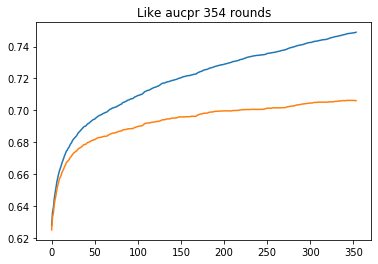

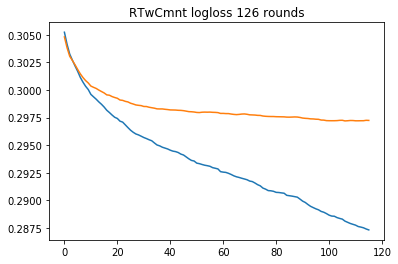

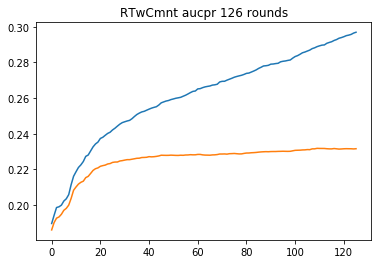

In [38]:
for tgt in tgt2evalres:
    evalres=tgt2evalres[tgt]
    plt.plot(evalres['train']['logloss'][10:])
    plt.plot(evalres['eval']['logloss'][10:])
    plt.title(f"{tgt} logloss {len(evalres['train']['logloss'])} rounds")
    plt.show()
    plt.plot(evalres['train']['aucpr'])
    plt.plot(evalres['eval']['aucpr'])
    plt.title(f"{tgt} aucpr {len(evalres['train']['aucpr'])} rounds")
    plt.show()

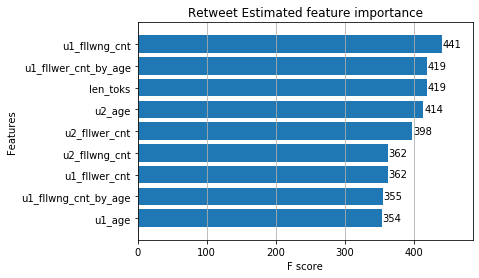

Retweet


,0,1
20,u1_fllwng_cnt,441
7,len_toks,419
12,u1_fllwer_cnt_by_age,419
6,u2_age,414
1,u2_fllwer_cnt,398
11,u2_fllwng_cnt,362
9,u1_fllwer_cnt,362
14,u1_fllwng_cnt_by_age,355
17,u1_age,354
27,twt_age,294


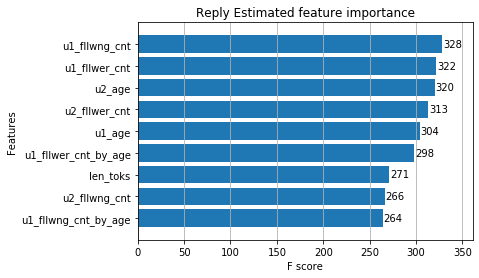

Reply


,0,1
5,u1_fllwng_cnt,328
8,u1_fllwer_cnt,322
2,u2_age,320
17,u2_fllwer_cnt,313
18,u1_age,304
13,u1_fllwer_cnt_by_age,298
19,len_toks,271
6,u2_fllwng_cnt,266
3,u1_fllwng_cnt_by_age,264
14,twt_age,193


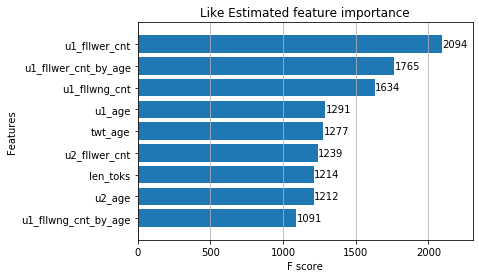

Like


,0,1
12,u1_fllwer_cnt,2094
10,u1_fllwer_cnt_by_age,1765
19,u1_fllwng_cnt,1634
7,u1_age,1291
16,twt_age,1277
11,u2_fllwer_cnt,1239
3,len_toks,1214
9,u2_age,1212
2,u1_fllwng_cnt_by_age,1091
8,u2_fllwng_cnt,1019


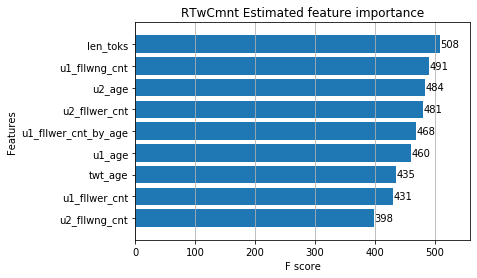

RTwCmnt


,0,1
14,len_toks,508
4,u1_fllwng_cnt,491
2,u2_age,484
0,u2_fllwer_cnt,481
18,u1_fllwer_cnt_by_age,468
15,u1_age,460
12,twt_age,435
19,u1_fllwer_cnt,431
16,u2_fllwng_cnt,398
24,u1_fllwng_cnt_by_age,394


In [39]:
def show_feat_importance(tgt):
    bst=tgt2bst[tgt]
    ax = xgb.plot_importance(bst, height=0.8, max_num_features=9)
    ax.grid(False, axis="y")
    ax.set_title(f'{tgt} Estimated feature importance')
    plt.show()
    feat2importance=bst.get_fscore()
    print(tgt)
    display(pd.DataFrame([feat2importance.keys(), 
                          feat2importance.values()]).T.sort_values(1, ascending=False))

for tgt in tgt2bst:
    show_feat_importance(tgt)

In [40]:
tgt2auc_tr={}
tgt2rce_tr={}
tgt2auc_vl={}
tgt2rce_vl={}
for tgt in tgt2bst:
    print(tgt)
    prdtr_i, prdvl_i = tgt2prdtr[tgt], tgt2prdvl[tgt]
    ytr_i, yvl_i = tgt2ytr[tgt], tgt2yvl[tgt]
    scr_auc_tr=compute_prauc(prdtr_i, ytr_i)
    scr_rce_tr=compute_rce(prdtr_i, ytr_i)
    scr_auc_vl=compute_prauc(prdvl_i, yvl_i)
    scr_rce_vl=compute_rce(prdvl_i, yvl_i)

    tgt2auc_tr[tgt]=scr_auc_tr
    tgt2rce_tr[tgt]=scr_rce_tr
    tgt2auc_vl[tgt]=scr_auc_vl
    tgt2rce_vl[tgt]=scr_rce_vl
    
    print('tr prauc:', f'{scr_auc_tr:.4f}','tr rce:', f'{scr_rce_tr:.4f}', )
    print('vl prauc:', f'{scr_auc_vl:.4f}','vl rce:', f'{scr_rce_vl:.4f}', )

Retweet
tr prauc: 0.3616 tr rce: 15.1659
vl prauc: 0.3180 vl rce: 12.1621
Reply
tr prauc: 0.3438 tr rce: 16.8069
vl prauc: 0.3168 vl rce: 14.9378
Like
tr prauc: 0.7482 tr rce: 20.0023
vl prauc: 0.7063 vl rce: 15.8378
RTwCmnt
tr prauc: 0.2924 tr rce: 12.1650
vl prauc: 0.2317 vl rce: 8.8335


In [41]:
lsttr=[]
lstvl=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    if tgt not in tgt2bst: continue
    lsttr+=[(f'PRAUC {tgt}',tgt2auc_tr[tgt]),
          (f'RCE {tgt}',tgt2rce_tr[tgt])]
    lstvl+=[(f'PRAUC {tgt}',tgt2auc_vl[tgt]),
          (f'RCE {tgt}',tgt2rce_vl[tgt])]

dfscrtr=pd.DataFrame(lsttr)
dfscrtr.columns=['metric','scr']
dfscrvl=pd.DataFrame(lstvl)
dfscrvl.columns=['metric','scr']
dfscr = pd.merge(dfscrtr, dfscrvl, on='metric', suffixes=('tr','vl'))
dfscr.T

,0,1,2,3,4,5,6,7
metric,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RTwCmnt,RCE RTwCmnt
scrtr,0.361607,15.1659,0.343831,16.8069,0.748169,20.0023,0.292366,12.165
scrvl,0.318025,12.1621,0.31685,14.9378,0.706278,15.8378,0.231675,8.83353


## valid

In [51]:
tgt=tgts[1]
tgtcol=tgt2col[tgt]
bst=tgt2bst[tgt]

dvalid=xgb.DMatrix(dfvalid[cols_feat], label=dfvalid[tgtcol], feature_names=cols_feat)

prdvalid = bst.predict(dvalid, ntree_limit=bst.best_ntree_limit)

pops=tgt2pops[tgt]

prdvalid[:10]
# array([0.11734424, 0.09971393, 0.05619054, 0.03059793, 0.07979691,
#        0.01358252, 0.05293725, 0.27954698, 0.05738379, 0.01741553],
#       dtype=float32)


pops
# {'train_pop': 4000000,
#  'target_pop': 109752,
#  'sampled_train_pop': 1000000,
#  'sampled_target_pop': 109752}

prdvalid_calib = calibration(prdvalid, **pops)

prdvalid_calib[:10]
# array([0.02952491, 0.02471944, 0.01344113, 0.00717127, 0.01945818,
#        0.00314114, 0.0126298 , 0.08155248, 0.01373977, 0.00403964],
#       dtype=float32)

In [62]:
def do_post_valid(tgt):
    tgtcol=tgt2col[tgt]
    bst=tgt2bst[tgt]
    pops=tgt2pops[tgt]
    dvalid=xgb.DMatrix(dfvalid[cols_feat], label=dfvalid[tgtcol], feature_names=cols_feat)
    prdvalid = bst.predict(dvalid, ntree_limit=bst.best_ntree_limit)
    prdvalid_calib = calibration(prdvalid, **pops)
    return prdvalid,prdvalid_calib

In [63]:
tgt2yvalid={tgt:dfvalid[tgt2col[tgt]] for tgt in tgts}
tgt2prdvalid={}
tgt2prdvalid_calib={}
for tgt in tgts:
    print(dtnow(), tgt)
    tgt2prdvalid[tgt],tgt2prdvalid_calib[tgt]=do_post_valid(tgt)


2020-03-23 18:48:40 Retweet
2020-03-23 18:48:50 Reply
2020-03-23 18:48:59 Like
2020-03-23 18:49:10 RTwCmnt


In [67]:
tgt2auc_valid={}
tgt2rce_valid={}
tgt2auc_valid_calib={}
tgt2rce_valid_calib={}
for tgt in tgts:
    print(dtnow(), tgt)
    prdvalid, prdvalid_calib = tgt2prdvalid[tgt], tgt2prdvalid_calib[tgt]
    yvalid = tgt2yvalid[tgt]
    scr_auc_valid=compute_prauc(prdvalid, yvalid)
    scr_rce_valid=compute_rce(prdvalid, yvalid)
    scr_auc_valid_calib=compute_prauc(prdvalid_calib, yvalid)
    scr_rce_valid_calib=compute_rce(prdvalid_calib, yvalid)

    tgt2auc_valid[tgt]=scr_auc_valid
    tgt2rce_valid[tgt]=scr_rce_valid
    tgt2auc_valid_calib[tgt]=scr_auc_valid_calib
    tgt2rce_valid_calib[tgt]=scr_rce_valid_calib

2020-03-23 18:54:31 Retweet
2020-03-23 18:54:32 Reply
2020-03-23 18:54:34 Like
2020-03-23 18:54:36 RTwCmnt


In [68]:
for tgt in tgts:
    print(tgt)
    print('tr           prauc:', f'{tgt2auc_tr[tgt]:.4f}','tr rce:', f'{tgt2rce_tr[tgt]:.4f}', )
    print('vl           prauc:', f'{tgt2auc_vl[tgt]:.4f}','tr rce:', f'{tgt2rce_vl[tgt]:.4f}', )
    print('valid        prauc:', f'{tgt2auc_valid[tgt]:.4f}','tr rce:', f'{tgt2rce_valid[tgt]:.4f}', )
    print('valid_calib  prauc:', f'{tgt2auc_valid_calib[tgt]:.4f}','tr rce:', f'{tgt2rce_valid_calib[tgt]:.4f}', )
    

Retweet
tr           prauc: 0.3616 tr rce: 15.1659
vl           prauc: 0.3180 tr rce: 12.1621
valid        prauc: 0.3147 tr rce: 12.1949
valid_calib  prauc: 0.3147 tr rce: 12.1949
Reply
tr           prauc: 0.3438 tr rce: 16.8069
vl           prauc: 0.3168 tr rce: 14.9378
valid        prauc: 0.1021 tr rce: -22.4393
valid_calib  prauc: 0.1021 tr rce: 11.5669
Like
tr           prauc: 0.7482 tr rce: 20.0023
vl           prauc: 0.7063 tr rce: 15.8378
valid        prauc: 0.7036 tr rce: 15.7299
valid_calib  prauc: 0.7036 tr rce: 15.7299
RTwCmnt
tr           prauc: 0.2924 tr rce: 12.1650
vl           prauc: 0.2317 tr rce: 8.8335
valid        prauc: 0.0228 tr rce: -160.2533
valid_calib  prauc: 0.0228 tr rce: 5.5675


In [77]:
lsttr=[]
lstvl=[]
lstvalid=[]
lstvalid_calib=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    if tgt not in tgt2bst: continue
    lsttr+=[(f'PRAUC {tgt}',tgt2auc_tr[tgt]),
          (f'RCE {tgt}',tgt2rce_tr[tgt])]
    lstvl+=[(f'PRAUC {tgt}',tgt2auc_vl[tgt]),
          (f'RCE {tgt}',tgt2rce_vl[tgt])]
    lstvalid+=[(f'PRAUC {tgt}',tgt2auc_valid[tgt]),
          (f'RCE {tgt}',tgt2rce_valid[tgt])]
    lstvalid_calib+=[(f'PRAUC {tgt}',tgt2auc_valid_calib[tgt]),
          (f'RCE {tgt}',tgt2rce_valid_calib[tgt])]

dfscrtr=pd.DataFrame(lsttr)
dfscrtr.columns=['metric','scr']
dfscrvl=pd.DataFrame(lstvl)
dfscrvl.columns=['metric','scr']
dfscrvalid=pd.DataFrame(lstvalid)
dfscrvalid.columns=['metric','scr']
dfscrvalid_calib=pd.DataFrame(lstvalid_calib)
dfscrvalid_calib.columns=['metric','scr']

dfscr = reduce(lambda df1,df2: pd.merge(df1,df2,on='metric'), 
            [dfscrtr,dfscrvl,dfscrvalid,dfscrvalid_calib])

dfscr.columns=['scr','tr','vl','valid','valid_calib']
dfscr.T

,0,1,2,3,4,5,6,7
scr,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RTwCmnt,RCE RTwCmnt
tr,0.361607,15.1659,0.343831,16.8069,0.748169,20.0023,0.292366,12.165
vl,0.318025,12.1621,0.31685,14.9378,0.706278,15.8378,0.231675,8.83353
valid,0.314666,12.1949,0.102055,-22.4393,0.703564,15.7299,0.0228217,-160.253
valid_calib,0.314666,12.1949,0.102055,11.5669,0.703564,15.7299,0.0228217,5.56753


# infer

In [78]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{valtmstmp}.tsv',
#     f'{p_in}/val_259A6F6DFD672CB1F883CBEC01B99F2D_1584405047.tsv',
    sep='\x01', header=None, names=cols_val,)


CPU times: user 1min 32s, sys: 10.6 s, total: 1min 42s
Wall time: 1min 42s


In [79]:
%%time
dftst = prp_df(dftst, istrn=False)

CPU times: user 1min 59s, sys: 12.7 s, total: 2min 11s
Wall time: 2min 11s


In [80]:
%%time
dtst = xgb.DMatrix(dftst[cols_feat], feature_names=cols_feat)
tgt2prdtst={}
for tgt in tgts:
    print(dtnow(), tgt)
    bst = tgt2bst[tgt]
    pops=tgt2pops[tgt]
    prdtst = bst.predict(dtst, ntree_limit=bst.best_ntree_limit)
    prdtst_calib = calibration(prdtst, **pops)
    tgt2prdtst[tgt] = prdtst_calib

2020-03-23 19:10:24 Retweet
2020-03-23 19:10:29 Reply
2020-03-23 19:10:34 Like
2020-03-23 19:11:03 RTwCmnt
CPU times: user 18min 23s, sys: 2min 49s, total: 21min 13s
Wall time: 2min 58s


In [81]:
dfsub_ids = dftst[['twtid','u2id',]]

tgt2dfsub = {}
for tgt,prdtst in tgt2prdtst.items():
    dfsub = dfsub_ids.copy()
    dfsub['scr'] = prdtst
    tgt2dfsub[tgt]=dfsub

In [82]:
%%time
for i,tgt in enumerate(['Retweet','Reply','RTwCmnt','Like',]):
    dfsub = tgt2dfsub[tgt]
    print(dtnow(), tgt)
    dfsub.to_csv(f'{p_out}/{i}_{tgt}__{valtmstmp}__{PRFX}.csv',index=False,header=False)

2020-03-23 19:11:14 Retweet
2020-03-23 19:12:12 Reply
2020-03-23 19:13:11 RTwCmnt
2020-03-23 19:14:10 Like
CPU times: user 3min 44s, sys: 9.12 s, total: 3min 53s
Wall time: 3min 53s
